# Tutorial on Linear Inverse Model (or Dynamical Mode Decomposition) on tropical SSTA

This is just a draft and not a finished tutorial yet.

TODO: Math

TODO: References

TODO: More Comments

In [1]:
import nc_time_axis
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy as ctp
import utils as ut

plt.style.use("../plotting.mplstyle")

## Load data

For simplicity we do not normalize the data here. Especially multivarible inputs need to be normalized.

In [2]:
da = xr.open_dataset("../AE_VAE/data/ssta_1950_2021.nc")['ssta']

Transform data into principal components:

In [3]:
pca = ut.SpatioTemporalPCA(da, n_components=10)
print(f"Explained variance: {np.sum(pca.explained_variance())}")
eof = pca.eofs()
pc = pca.principal_components() 

Explained variance: 0.700825299289874


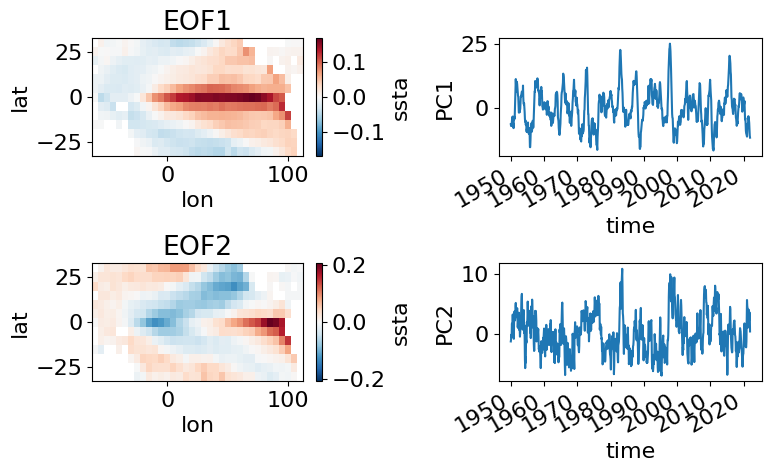

In [4]:
# Plot EOFs and PCs
n_comp_plot = 2
fig = plt.figure(figsize=(2 * 4, 2.5* n_comp_plot))
for i in range(n_comp_plot):
    # Plot time evolution
    idx_plot = 2 * i + 1
    ax = fig.add_subplot(n_comp_plot, 2, 2*i+1)
    eof[i].plot(ax=ax)
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(n_comp_plot, 2, 2*i + 2)
    pc.isel(eof=i).plot(ax=ax)
    ax.set_ylabel(f"PC{i+1}")

Split data into training and test set:

In [5]:
# Split in training and test data
data = pca.principal_components()
idx_train = int(0.8*len(data['time']))
data_train = data[:,:idx_train]
data_test = data[:,idx_train:]

## Stationary LIM

Implementing the LIM.

In [6]:
class LIM:
    """Create Linear Inverse model.

    Args:
        tau (int): Time-lag.
    """
    def __init__(self, tau) -> None:
        self.tau_0 = tau

        # Empty class variables
        self.G = None
        self.L = None
        self.Q = None
    
    def fit(self, data):
        """Fit LIM to data.

        Args:
            data (np.ndarray): Input data to estimate Green's function from.
                Dimensions (n_components, n_time). 
        """
        x = data[:, :-self.tau_0]
        x_tau = data[:, self.tau_0:]
        assert x.shape == x_tau.shape
        n_time = data.shape[1] - self.tau_0

        # Covariance matrices
        self.C_0 = (x @ x.T) / n_time
        self.C_tau = (x_tau @ x.T) / n_time

        # Compute time-evolution operator
        self.G = self.C_tau @ np.linalg.inv(self.C_0) # less efficient

        # Compute L = ln(G)/tau.
        w, U, V = ut.matrix_decomposition(self.G)

        # Sort by decay time
        t_decay = - self.tau_0 / np.log(w)
        idx_sort = np.argsort(t_decay)[::-1]
        w = w[idx_sort]
        U = U[:,idx_sort]
        V = V[:,idx_sort]

        log_W = np.diag(np.log(w) / self.tau_0) 
        # Compute L = U @ log(W)/tau @ U^-1
        L = U @ log_W @ np.linalg.inv(U)
        
        # Nyquist mode check
        eps = 1e-5
        if np.max(np.abs(np.imag(L))) > eps:
            print("WARNING: Risk of nyquist mode.")
            print(f"WARNING: The imaginary part of L is {np.max(np.abs(np.imag(L)))}!")
            print(f"WARNING: Eigval of G are [{np.min(w)}, {np.max(w)}]!")
            self.L = L
        else:
            self.L = np.real(L)

        self.Q = self.noise_covariance()

        return None


    def noise_covariance(self):
        """Estimate noise covariance using the stationarity assumption.
            0 = L @ C_0 + C_0 @ L.T + Q 
        Returns:
            Q (np.ndarray): Estimated noise covariance of 
                dimensions (n_components, n_components).
        """
        Q = - self.L @ self.C_0 - self.C_0 @ self.L.T

        if np.min(Q) < -1e-5: 
            print(f"WARNING: Covariance matrix has negative values!")

        # Nyquist mode check 2
        w_Q, _,_ = ut.matrix_decomposition(Q)
        eps = 1e-5
        if np.max(np.abs(np.imag(w_Q))) > eps:
            print(f"WARNING: Imaginary part of max eigval of Q are {np.max(np.abs(np.imag(w_Q)))}!")

        return Q
    

    def forecast_mean(self, x, lag=1):
        """Forecasting mean. 

            x(t+tau) = G x(t)

        Args:
            x (np.ndarray): Input data to estimate Green's function from.
                Dimensions (n_components, n_time). 

        Returns:
            x_frcst (np.ndarray): Forecast.
                Dimensions (n_components, n_time). 
        """
        w, U, V = ut.matrix_decomposition(self.G)

        # Sort by decay time
        t_decay = - self.tau_0 / np.log(w)
        idx_sort = np.argsort(t_decay)[::-1]
        w = w[idx_sort]
        U = U[:,idx_sort]
        V = V[:,idx_sort]

        weights = U.T @ V
        U_norm = U @ np.linalg.inv(weights)

        G_tau = U_norm @ np.diag(w**(lag/self.tau_0)) @ V.T 
        x_frcst = np.einsum('ij,jk', np.real(G_tau), x)
        return x_frcst


    def error_covariance(self, power=1):
        """Error covariance.

        e**2 = C_0 - G_tau C_0 G_tau.T

        Args:
            power (int, optional): Power of G, i.e. G**power. For example power=tau/lag.
                Defaults to 1.

        Returns:
            error_cov (np.ndarray): Error covariance of dimension 
                (n_components, n_components). 
        """
        w, U, V = ut.matrix_decomposition(self.G)
        G_tau = U @ np.diag(w**power) @ np.linalg.inv(U) 
        error_cov = self.C_0 - G_tau @ self.C_0 @ G_tau.T

        return error_cov

Create a LIM object:

In [7]:
tau = 1
model = LIM(tau)
model.fit(data_train.data)

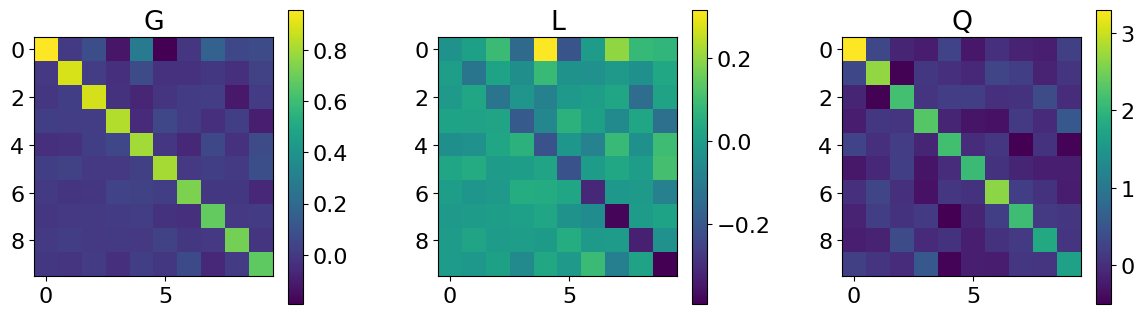

In [8]:
# Plot G
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
pos = axs[0].imshow(model.G)
axs[0].set_title('G')
fig.colorbar(pos, ax=axs[0])
pos = axs[1].imshow(np.real(model.L))
axs[1].set_title('L')
fig.colorbar(pos, ax=axs[1])
pos = axs[2].imshow(np.real(model.Q))
axs[2].set_title('Q')
fig.colorbar(pos, ax=axs[2])

Forecast:

Text(0.5, 0, 'time')

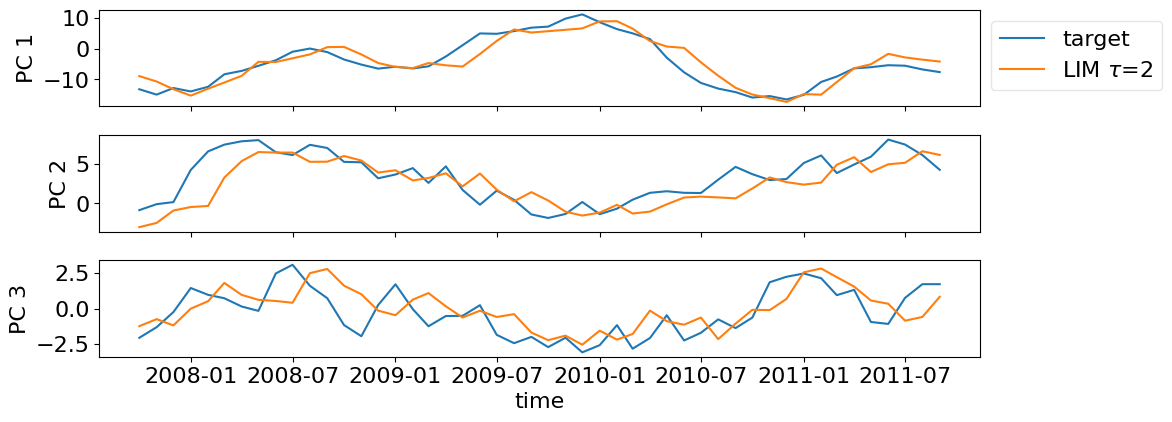

In [9]:
lag=2
x_input = data_test.isel(time=np.arange(0, 50))
times = x_input['time']
x = x_input.data
x_frcst = model.forecast_mean(x, lag=lag)

# Plot time evolution
idx_components = [0,1,2]
fig, axs = plt.subplots(len(idx_components), figsize=(12, len(idx_components)*1.5), sharex=True)
for i, c in enumerate(idx_components):
    axs[i].plot(times[lag:], x[c, lag:], label='target') 
    axs[i].plot(times[lag:], x_frcst[c, :-lag], label=rf'LIM $\tau$={lag}') 
    axs[i].set_ylabel(f'PC {i+1}')

_ = axs[0].legend(bbox_to_anchor=(1,1), loc="upper left")
axs[-1].set_xlabel('time')

Transform back to data space (denoted with y) and plot random forecast example:

In [10]:
# Transform to dataspace
times = data_test.isel(time=time_range)['time'][lag:]
y = pca.reconstruction(x[:, lag:], newdim=times)
y_frcst = pca.reconstruction(x_frcst[:, :-lag], newdim=times)

t_idx = 5 

plparam = {'tsa': dict(vmin=-2, vmax=2, eps=0.25),
           'zosa': dict(vmin=-0.1, vmax=.1, eps=0.025)}

fig, axs = plt.subplots(1,2, figsize=(10, 3))
y.isel(time=t_idx).plot(ax=axs[0])
axs[0].set_title("target")
y_frcst.isel(time=t_idx).plot(ax=axs[1])
axs[1].set_title("forecast")

NameError: name 'time_range' is not defined

## Optimal growth

In [ ]:
lag_arr = np.arange(1, 24, 1)
growth_arr = []
for lag in lag_arr:
    w, U, V = ut.matrix_decomposition(model.G)
    G_tau = U @ np.diag(w**(lag/model.tau_0)) @ np.linalg.inv(U)
    w_tau, U_tau, V_tau = ut.matrix_decomposition(G_tau.T @ G_tau)
    growth_arr.append(w_tau[0])

In [ ]:
# Plot growth
fig, ax = plt.subplots()
ax.plot(lag_arr, np.log(growth_arr), 'o-', label='growth')
_ = ax.set_xlabel(r"$\tau$")
_ = ax.set_ylabel(r"$log(\gamma)$")
_ = ax.set_title(rf"Optimal growth ($\tau_0$={model.tau_0})")
ax.grid('y')